In [1]:
import glob
import pandas as pd
import numpy as np
import sys
import operator
import numpy as np
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline
pd.options.display.max_columns = None

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
## COMMANDS TO DOWNLOAD STUFF

#!wget -nc -O data/2016_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2016/2016_manhattan.xls
#!wget -nc -O data/2015_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2015/2015_manhattan.xls
#!wget -nc -O data/2014_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2014/2014_manhattan.xls
# !wget -nc -O data/2013_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2013/2013_manhattan.xls
# !wget -nc -O data/2012_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2012/2012_manhattan.xls
# !wget -nc -O data/2011_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2011/2011_manhattan.xls
# !wget -nc -O data/2010_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2010/2010_manhattan.xls
# !wget -nc -O data/2009_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_manhattan.xls
# !wget -nc -O data/2008_manhattan.xls http://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_manhattan.xls

In [14]:
q.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,ALPHABET CITY,01 ONE FAMILY HOMES,1,402,42,,S1,96 AVENUE B,,10009,1,1,2,1400,1839,1901,1,S1,20000,2008-12-04
1,1,ALPHABET CITY,01 ONE FAMILY HOMES,1,402,42,,S1,96 AVENUE B,,10009,1,1,2,1400,1839,1901,1,S1,20000,2008-12-03
2,1,ALPHABET CITY,01 ONE FAMILY HOMES,1,402,42,,S1,96 AVENUE B,,10009,1,1,2,1400,1839,1901,1,S1,20000,2008-11-25
3,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,377,66,,C0,243 EAST 7TH STREET,,10009,3,0,3,2381,3084,1899,1,C0,3350000,2008-08-26
4,1,ALPHABET CITY,03 THREE FAMILY HOMES,1,389,29,,A5,222 EAST 7TH STREET,,10009,1,0,1,2272,5516,1901,1,C0,3200000,2008-09-18


In [13]:
# w r a n g l e + load
poi_pluto = gpd.GeoDataFrame(gpd.read_file("PLUTO/area_of_interest5.shp"))

files = glob.glob("data/*.xls")
q = None
dfs = [pd.read_excel(f, skiprows=(4 if '2008' not in f and '2009' not in f and '2010' not in f else 3)) for f in files]
for f, df in zip(files, dfs):
    if '2008' in f:
        q = df
    df.columns = ["_".join(x.strip().split(" ")) for x in df.columns]

manhattan_sales = pd.concat(dfs)
merged = manhattan_sales.merge(poi_pluto, left_on=["BLOCK", "LOT"], right_on=["Block", "Lot"])
merged["SALE_MONTH"] = merged["SALE_DATE"].apply(lambda x: str(x.year) + "-" + str(x.month))
l = list(merged.columns)
l.remove("geometry")
merged = merged.drop_duplicates(subset=l)
merged = merged[merged["SALE_PRICE"] > 1]
merged["APT"] = merged["ADDRESS"].str.split(",").apply(lambda x: x[1].strip() if len(x) > 1 else "")
def dude(x):
    return x["APARTMENT_NUMBER"].strip() if x["APARTMENT_NUMBER"].strip() else x["APT"]

merged["APARTMENT_NUMBER"] = merged["APARTMENT_NUMBER"].astype(str)
merged["APT_2"] = merged[["APT", "APARTMENT_NUMBER"]].apply(dude, axis=1)
merged["APT"] = merged["APT_2"]
merged = merged[merged["YearBuilt"] > 0].reset_index(drop=True)
df = merged

df["address_apt"] = df["Address"].apply(lambda x: x.strip() + " # ") + df["APT"]
# filter out things that arent apartments
df = df[df["APT"] != ''].reset_index(drop=True)
df["log_price"] = np.log(df["SALE_PRICE"])
df = df[df["log_price"] > 5].reset_index(drop=True) # 100k

In [21]:
np.sort(df["SALE_DATE"].apply(lambda x: x.year).unique())

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [ ]:
two_or_more_sales.groupby(["Address", "APT"]).size().describe()

### Regressions with basic variables

0.241089688206
0.164255260952
0.00105770947956
-0.116288358826


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     78.93
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           1.10e-50
Time:                        15:33:01   Log-Likelihood:                -22974.
No. Observations:               16301   AIC:                         4.596e+04
Df Residuals:                   16297   BIC:                         4.599e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.8013      0.009   1610.582      0.000      13.785      13.818
treatment            -0.3886      0.026    -14.964      0.000      -0.439      -0.338
after                 0.0644      0.030      2.127      0.033       0.005       0.124
treatment_x_after     0.2411      0.093      2.603      0.009       0.060       0.423
==============================================================================
Omnibus:                      808.463   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2227.443
Skew:                           0.249   Prob(JB):                         0.00
Kurtosis:                       4.741   Cond. No.                         12.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

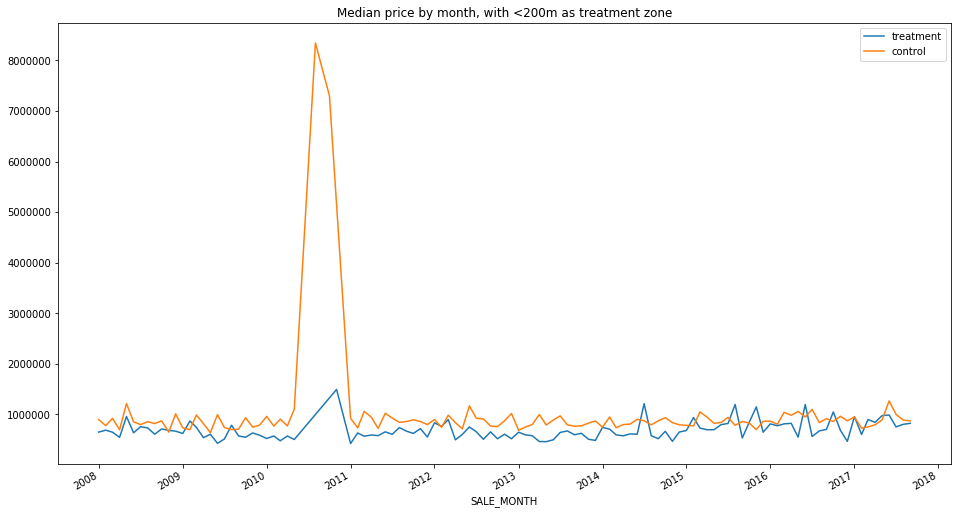

In [23]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = (df["distance"] < 200).astype(np.int)
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = df[df["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = df[df["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment")
median_control.plot(ax=ax, label="control")
ax.legend()
ax.set_title("Median price by month, with <200m as treatment zone")
reg_all.summary()

### Regressions with east of second avenue

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


In [ ]:
from datetime import datetime
cutoff = datetime(2017, 1, 1)

# make our features

# treatment and before / after
df["treatment"] = df["east_or__1"]
df["after"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["treatment_x_after"] = df["treatment"] * df["after"]


df["prewar"] = (df["YearBuilt"] < 1950).astype(np.int)
df["postwar"] = (df["YearBuilt"] >= 1950).astype(np.int)
df["new"] = (df["YearBuilt"] >= 2000).astype(np.int)
year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment + after + treatment_x_after"
reg_all = smf.ols(basic_formula, data=df).fit()
reg_two = smf.ols(basic_formula, data=two_or_more_sales).fit()
reg_only = smf.ols(basic_formula, data=only_before_after).fit()
reg_br = smf.ols(basic_formula + " + bedrooms", data=with_br).fit()

print reg_all.params['treatment_x_after']
print reg_two.params['treatment_x_after']
print reg_only.params['treatment_x_after']
print reg_br.params['treatment_x_after']

fig = plt.figure(figsize=(16, 9))

median_treatment = df[df["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = df[df["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

ax = median_treatment.plot(figsize=(16, 9), label="treatment", linewidth=4, )
median_control.plot(ax=ax, label="control", linewidth=4)
ax.axvline(cutoff, color='r', linestyle='--', linewidth=4, label="SAS Opening")
ax.set_title("Median price by month, with east of 2nd avenue as treatment zone")
ax.set_ylabel("Sale Price ($$$)")
ax.set_xlabel("Sale Month")

## Check out some anticipation effects

In [ ]:
from datetime import datetime, timedelta
opening = datetime(2017, 1, 1)
anti_6mo = opening - timedelta(days=182)
print anti_6mo
anti_1yr = opening - timedelta(days=365)
# make our features

# treatment and before / after
df["treatment"] = df["east_or__1"]
df["after_op"] = (df["SALE_DATE"] >= cutoff).astype(np.int)
df["at_6mo"] = (df["SALE_DATE"] >= anti_6mo).astype(np.int)
df["at_1yr"] = (df["SALE_DATE"] >= anti_1yr).astype(np.int)

df["treatment_x_after_op"] = df["treatment"] * df["after"]
df["treatment_x_after_6mo"] = df["treatment"] * df["at_6mo"]
df["treatment_x_after_1yr"] = df["treatment"] * df["at_1yr"]

year_cols = "prewar + postwar + new"

two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)

import bedrooms as br
reload(br)
with_br = only_before_after.merge(br.br, left_on="address_apt", right_on='addy')

import statsmodels.formula.api as smf


basic_formula = "log_price ~ treatment"
formula_6mo = basic_formula + " + at_6mo + treatment_x_after_6mo"
formula_1yr = basic_formula + " + at_1yr + treatment_x_after_1yr"
formula_6mo_time_of = formula_6mo + " + after_op + treatment_x_after_op"
reg_br_6mo_only = smf.ols(formula_6mo + " + bedrooms", data=with_br).fit()
reg_br_1yr_only = smf.ols(formula_1yr + " + bedrooms", data=with_br).fit()
reg_br_6mo_1yr = smf.ols(formula_6mo_time_of + " + bedrooms", data=with_br).fit()
fig = plt.figure(figsize=(16, 9))

median_treatment = two_or_more_sales[two_or_more_sales["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_control = two_or_more_sales[two_or_more_sales["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
median_treatment.index = median_treatment.index.map(lambda x: pd.to_datetime(x))
median_control.index = median_control.index.map(lambda x: pd.to_datetime(x))

In [ ]:
reg_br_1yr_only.summary()

In [ ]:
reg_br_6mo_only.summary()

In [ ]:
reg_br_6mo_1yr.summary()

## Make the plot of before / after prices at distance x distance

In [ ]:
df["distance_100"] = (df["distance"] / 100).astype(np.int)
ax = df[df["after_op"] == 1].groupby("distance_100").median()["SALE_PRICE"].plot(label="after", figsize=(16, 9), linewidth=4)
ax = df[df["after_op"] == 0].groupby("distance_100").median()["SALE_PRICE"].plot(ax=ax, label="before", linewidth=4)
ax.legend()
ax.set_xlabel("distance (x 100m)")
ax.set_ylabel("sale price ($)")
ax.set_xlim(0, 6)
ax.set_ylim(500000, 1000000)

## Use Log Price

It is more normal by tests.

In [ ]:
ax = df["log_price"].hist(figsize=(16, 9))
ax.set_title("Log sale price of UES sales data for apartments")
ax.set_xlabel("Log sale price")
ax.set_ylabel("Count")

### LaTeX Formatting

In [ ]:
df.head(1)

In [ ]:
len(df)

## General Descriptives

In [ ]:
old_format = pd.options.display.float_format
pd.options.display.float_format = '${:,.2f}'.format

In [ ]:
desc1 = df[(df["treatment"] == 1) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc1.columns = ["Sale Price (east of second avenue), before"]
desc2 = df[(df["treatment"] == 1) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc2.columns = ["Sale Price (east of second avenue), after"]
desc3 = df[(df["treatment"] == 0) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc3.columns = ["Sale Price (west of second avenue), before"]
desc4 = df[(df["treatment"] == 0) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc4.columns = ["Sale Price (west of second avenue), after"]

desc1.join(desc2).join(desc3).join(desc4)

In [ ]:
df = old_df
df["treatment"] = df["east_or__1"]
two_or_more_sales = df.groupby(["Address", "APT"]).filter(lambda x: len(x) > 1)
only_before_after = two_or_more_sales.groupby(["ADDRESS", "APT"]).filter(lambda x: x.SALE_DATE.min() < cutoff\
                                                               and x.SALE_DATE.max() >= cutoff)


In [ ]:
desc1 = df[(df["treatment"] == 1) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc1.columns = ["Sale Price (<200m), before"]
desc2 = df[(df["treatment"] == 1) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc2.columns = ["Sale Price (<200m), after"]
desc3 = df[(df["treatment"] == 0) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc3.columns = ["Sale Price (>=200m), before"]
desc4 = df[(df["treatment"] == 0) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc4.columns = ["Sale Price (>=200m), after"]

desc1.join(desc2).join(desc3).join(desc4)

In [ ]:
desc1 = df[(df["treatment"] == 1) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc1.columns = ["Sale Price (<200m), before"]
desc2 = df[(df["treatment"] == 1) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc2.columns = ["Sale Price (<200m), after"]
desc3 = df[(df["treatment"] == 0) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc3.columns = ["Sale Price (>=200m), before"]
desc4 = df[(df["treatment"] == 0) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc4.columns = ["Sale Price (>=200m), after"]

desc1.join(desc2).join(desc3).join(desc4)

In [ ]:
old_df = df
df = only_before_after

desc1 = df[(df["treatment"] == 1) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc1.columns = ["Sale Price (east of second avenue), before"]
desc2 = df[(df["treatment"] == 1) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc2.columns = ["Sale Price (east of second avenue), after"]
desc3 = df[(df["treatment"] == 0) & (df["after_op"] == 0)][["SALE_PRICE"]].describe()
desc3.columns = ["Sale Price (west of second avenue), before"]
desc4 = df[(df["treatment"] == 0) & (df["after_op"] == 1)][["SALE_PRICE"]].describe()
desc4.columns = ["Sale Price (west of second avenue), after"]

desc1.join(desc2).join(desc3).join(desc4)

# volume plots

In [ ]:
grouped = df[df["treatment"] == 1].groupby("SALE_MONTH").median()["SALE_PRICE"]
grouped.index = pd.to_datetime(grouped.index)
ax = grouped.plot(label="treatment zone (east of 2nd ave)", linewidth=4)
grouped = df[df["treatment"] == 0].groupby("SALE_MONTH").median()["SALE_PRICE"]
grouped.index = pd.to_datetime(grouped.index)
grouped.plot(ax=ax, label="control zone (west of 2nd ave)", figsize=(16, 9), linewidth=4)
ax.axvline(cutoff, color='r', linestyle='--', linewidth=4, label="SAS Opening")
ax.set_xlim(datetime(2016, 1,1 ), datetime(2017, 9, 1))
ax.set_xlabel("Sale Month")
ax.set_ylabel("Sale Price ($$$)")
ax.legend()
"""
CAPTION: we see that the whole neighborhood heated up through 2016. 
It appears yorkville was even a bit delayed beyond the UES market heating up.
"""

In [ ]:
df["treatment"] = (df["distance"] < 200).astype(np.int)
grouped = df[df["treatment"] == 1].groupby("SALE_MONTH").count()["SALE_PRICE"]
grouped.index = pd.to_datetime(grouped.index)
ax = grouped.plot(label="treatment zone (<200m)")
grouped = df[df["treatment"] == 0].groupby("SALE_MONTH").count()["SALE_PRICE"]
grouped.index = pd.to_datetime(grouped.index)
grouped.plot(ax=ax, label="control zone (>=200m)")
ax.set_xlim(datetime(2016, 1,1 ), datetime(2017, 1, 1))
ax.legend()
ax.title("Sale volume for treament within 200m vs. control")
"""
CAPTION: the scales are weird because there are fewer absolute sales, but 
we do see the treatment area heated up through 2016
"""

In [ ]:
ax = with_br.plot("bedrooms", "log_price", kind="scatter", figsize=(16, 9))
with_br[["bedrooms", "log_price"]].corr()
ax.set_xlabel("# of bedrooms")
ax.set_ylabel("Log Sale Price (log-dollars)")
ax.set_title("Log-price vs. Bedrooms")
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(["0 (Studio)", 1, 2, 3, 4])

In [ ]:

def gen_vol_plot(bedrooms, title=None, ax=None, line_label=None, v=False):
    sales_vols = with_br[with_br["bedrooms"] == bedrooms]["SALE_MONTH"]\
                   .value_counts()
    sales_vols.index = sales_vols.index.map(lambda x: pd.to_datetime(x))
    ax2 = sales_vols.plot(figsize=(16, 9), ax=ax, label=line_label, linewidth=3)
    if not ax:
        ax2.set_xlabel("Year - Month")
        ax2.set_ylabel("Volume (# sales)")
    ax2.set_title("Volumes over time" if not title else title)
    if v:
        ax2.axvline(datetime(2017, 1, 1), c='r', linestyle='--', label='SAS opening')
        ax2.legend()
    return ax2, l

In [ ]:
with_br.groupby("")

In [ ]:
interesting.head()["delta_years"].astype(np.int)

In [ ]:
n[3][["SALE_DATE", "SALE_PRICE"]].iloc[-1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            delta_price   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                 -0.119
Method:                 Least Squares   F-statistic:                    0.7390
Date:                Thu, 07 Dec 2017   Prob (F-statistic):              0.708
Time:                        15:33:45   Log-Likelihood:                 23.129
No. Observations:                  33   AIC:                            -18.26
Df Residuals:                      19   BIC:                             2.693
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1488      0.053      2.808      0.011       0.038       0.260
Q("q2008-1")    -0.0906      0.108     -0.837      0.413      -0.317       0.136
Q("q2009-0")  1.352e-17   3.46e-17      0.391      0.700   -5.88e-17    8.59e-17
Q("q2009-1")  1.131e-18   4.19e-17      0.027      0.979   -8.65e-17    8.88e-17
Q("q2010-0") -3.375e-17   3.02e-17     -1.119      0.277   -9.69e-17    2.94e-17
Q("q2011-0")  2.551e-17    3.7e-17      0.689      0.499    -5.2e-17    1.03e-16
Q("q2011-1") -2.177e-17   1.98e-17     -1.101      0.285   -6.32e-17    1.96e-17
Q("q2012-1")  5.419e-17   6.71e-17      0.808      0.429   -8.62e-17    1.95e-16
Q("q2012-2")    -0.0378      0.094     -0.401      0.693      -0.235       0.160
Q("q2013-0") -2.511e-17    6.1e-17     -0.412      0.685   -1.53e-16    1.03e-16
Q("q2013-1")     0.0559      0.154      0.364      0.720      -0.266       0.378
Q("q2014-0")     0.0888      0.075      1.187      0.250      -0.068       0.245
Q("q2014-1")     0.0574      0.081      0.712      0.485      -0.111       0.226
Q("q2014-2")     0.1012      0.118      0.860      0.401      -0.145       0.347
Q("q2015-0")    -0.0861      0.112     -0.768      0.452      -0.321       0.149
Q("q2015-1")    -0.0781      0.062     -1.251      0.226      -0.209       0.053
Q("q2015-2")     0.0185      0.109      0.171      0.866      -0.209       0.246
Q("q2016-0")     0.1441      0.157      0.918      0.370      -0.184       0.473
Q("q2016-1")    -0.0244      0.156     -0.157      0.877      -0.350       0.301
Q("q2017-0")     0.0108      0.061      0.178      0.861      -0.117       0.138
Q("q2017-1")     0.0364      0.051      0.719      0.481      -0.070       0.143
Q("q2017-2")     0.1015      0.094      1.082      0.293      -0.095       0.298
delta_dist    6.131e-06      0.000      0.025      0.980      -0.001       0.001
==============================================================================
Omnibus:                        2.246   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                1.134
Skew:                          -0.129   Prob(JB):                        0.567
Kurtosis:                       3.871   Cond. No.                     1.84e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  8e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

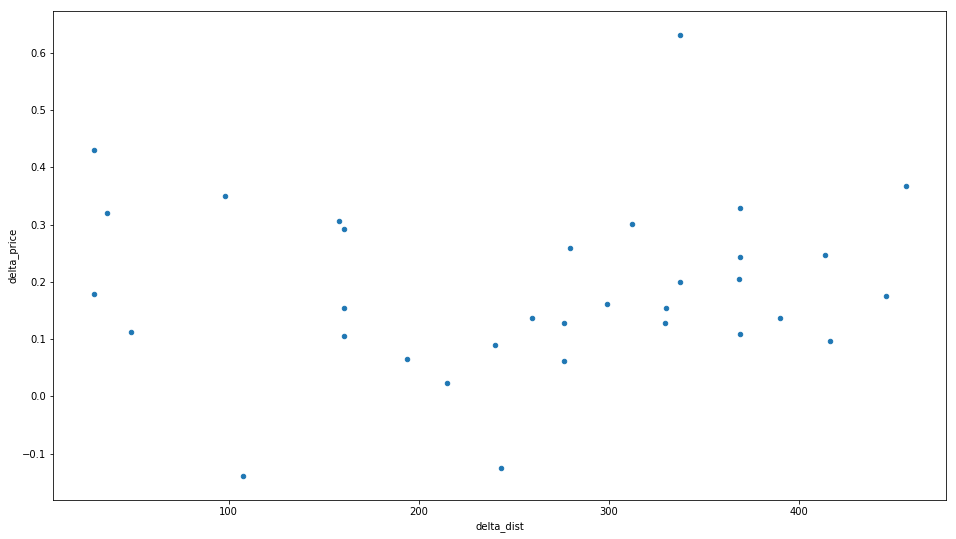

In [24]:
n = []
def get_deltas(g):
    global n
    sort = g.sort_values("SALE_DATE")
    n.append(sort)
    first = sort.iloc[0]
    last = sort.iloc[-1]
    delta_price = last["log_price"] - first["log_price"]
    if last.SALE_DATE.year == 2017:
        delta_dist = np.max([last['distance_1'] - last['distance'], 0])
    else:
        delta_dist = 0.
    
    num_bedrooms = last["bedrooms"] if 'bedrooms' in last else 0
    
    resale_quarter = str(last.SALE_DATE.year) + "-" + str(int((last.SALE_DATE.month - 1) / 4))
    sale_quarter = str(first.SALE_DATE.year) + "-" + str(int((first.SALE_DATE.month - 1) / 4))
    renovate = 0
    for field in ["YearAlter1", "YearAlter2"]:
        if first.SALE_DATE.year <= first[field] and last.SALE_DATE.year >= last[field]:
            renovate = 1
            
    return pd.Series([ delta_price,  delta_dist, resale_quarter, sale_quarter, renovate, num_bedrooms] , index=["delta_price", 
                                                                                        "delta_dist",
                                                                                        "resale_quarter",
                                                                                        "sale_quarter", "renovate", "num_bedrooms"])
interesting = with_br.groupby("address_apt").apply(lambda x: get_deltas(x))
#interesting.plot('delta_dist', 'delta_price', kind='scatter')
q = np.polyfit(interesting['delta_dist'], interesting['delta_price'], 1)
#plt.plot(np.arange(500), np.arange(500) * q[0] + q[1], 'r-')
sale_quarter = pd.get_dummies(interesting["sale_quarter"])
sale_quarter.columns = ["q"+x for x in sale_quarter.columns]
resale_quarter = pd.get_dummies(interesting["resale_quarter"])
resale_quarter.columns = ["q"+x for x in resale_quarter.columns]
sale_quarter
cols = ['Q("{}")'.format(x) for x in list(sale_quarter.columns) + list(resale_quarter.columns)]
reg_cols = " + ".join(cols + ["delta_dist"])
interesting_j = interesting.join(sale_quarter).join(resale_quarter)
interesting_j = interesting_j[(interesting_j["delta_price"] < 1.5) & (interesting_j["delta_dist"] > 0)]
interesting_j.plot("delta_dist", "delta_price", kind="scatter", figsize=(16, 9))
smf.ols("delta_price ~ {}".format(reg_cols), data=interesting_j).fit().summary()


In [ ]:
interesting.plot("num_bedrooms", "delta_price", kind="scatter")

In [ ]:
with_br.YearAlter2.unique()

In [25]:
all_sales_times = two_or_more_sales.groupby("address_apt").apply(lambda x: get_deltas(x))
all_sales_times = all_sales_times[all_sales_times["resale_quarter"] != all_sales_times["sale_quarter"]]
sale_quarter = -1 * pd.get_dummies(all_sales_times["sale_quarter"])
sale_quarter.columns = ["q"+x for x in sale_quarter.columns]
resale_quarter = pd.get_dummies(all_sales_times["resale_quarter"])
resale_quarter.columns = ["q"+x for x in resale_quarter.columns]
sale_and_resale = sale_quarter.join(resale_quarter, rsuffix="rs")
for col in sale_and_resale:
    if 'rs' not in col and (col + 'rs') in sale_and_resale:
        sale_and_resale[col + "_final"] = sale_and_resale[col + "rs"] + sale_and_resale[col]
ready_to_regress = all_sales_times.join(sale_and_resale)
cols = ['Q("{}")'.format(x) for x in sale_and_resale.columns if 'rs' not in x and (x + '_final') not in sale_and_resale]
reg_cols = " + ".join(cols + ["delta_dist", "renovate"])
smf.ols("delta_price ~ {}".format(reg_cols), data=ready_to_regress[(ready_to_regress["delta_price"] > -.5)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            delta_price   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     7.493
Date:                Thu, 07 Dec 2017   Prob (F-statistic):           1.53e-29
Time:                        15:34:02   Log-Likelihood:                -525.22
No. Observations:                1811   AIC:                             1112.
Df Residuals:                    1780   BIC:                             1283.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1796      0.019      9.493      0.000       0.143       0.217
Q("q2008-0")           0.1237      0.028      4.388      0.000       0.068       0.179
Q("q2016-2")           0.0724      0.031      2.305      0.021       0.011       0.134
Q("q2017-0")           0.0667      0.036      1.828      0.068      -0.005       0.138
Q("q2017-1")           0.0677      0.029      2.347      0.019       0.011       0.124
Q("q2017-2")           0.1878      0.070      2.664      0.008       0.050       0.326
Q("q2008-1_final")     0.0858      0.028      3.113      0.002       0.032       0.140
Q("q2008-2_final")     0.0772      0.033      2.330      0.020       0.012       0.142
Q("q2009-0_final")     0.0080      0.040      0.200      0.842      -0.071       0.087
Q("q2009-1_final")    -0.0988      0.032     -3.107      0.002      -0.161      -0.036
Q("q2009-2_final")    -0.0661      0.029     -2.281      0.023      -0.123      -0.009
Q("q2010-0_final")    -0.0756      0.031     -2.461      0.014      -0.136      -0.015
Q("q2010-1_final")    -0.0705      0.059     -1.188      0.235      -0.187       0.046
Q("q2011-0_final")    -0.1775      0.035     -5.033      0.000      -0.247      -0.108
Q("q2011-1_final")    -0.0539      0.029     -1.848      0.065      -0.111       0.003
Q("q2011-2_final")    -0.0965      0.034     -2.820      0.005      -0.164      -0.029
Q("q2012-0_final")    -0.1713      0.034     -5.015      0.000      -0.238      -0.104
Q("q2012-1_final")    -0.1273      0.027     -4.695      0.000      -0.181      -0.074
Q("q2012-2_final")    -0.0644      0.027     -2.361      0.018      -0.118      -0.011
Q("q2013-0_final")    -0.0805      0.032     -2.536      0.011      -0.143      -0.018
Q("q2013-1_final")     0.0145      0.024      0.603      0.546      -0.033       0.062
Q("q2013-2_final")     0.0020      0.028      0.072      0.943      -0.053       0.057
Q("q2014-0_final")    -0.0073      0.030     -0.248      0.804      -0.065       0.051
Q("q2014-1_final")     0.0162      0.026      0.619      0.536      -0.035       0.068
Q("q2014-2_final")     0.0337      0.033      1.020      0.308      -0.031       0.098
Q("q2015-0_final")     0.0293      0.032      0.928      0.353      -0.033       0.091
Q("q2015-1_final")     0.0662      0.026      2.592      0.010       0.016       0.116
Q("q2015-2_final")     0.0830      0.029      2.830      0.005       0.025       0.141
Q("q2016-0_final")     0.0905      0.031      2.894      0.004       0.029       0.152
Q("q2016-1_final")     0.0650      0.028      2.298      0.022       0.010       0.121
delta_dist             0.0002      0.000      1.717      0.086    -2.8e-05       0.000
renovate               0.0146      0.036      0.402      0.688      -0.057       0.086
======================================

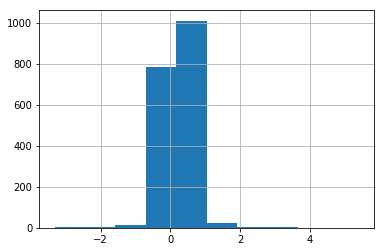

In [26]:
ready_to_regress["delta_price"].hist()

In [ ]:
interesting.renovate.unique()

In [ ]:
sale_quarter.columns

In [ ]:
resale_quarter.columns

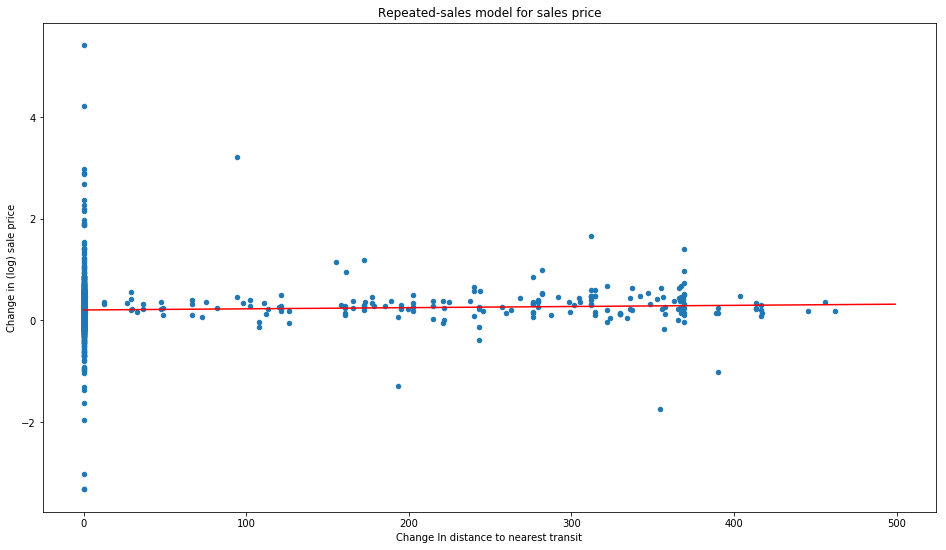

In [27]:
ax = ready_to_regress.plot('delta_dist', 'delta_price', kind='scatter', figsize=(16, 9))
q = np.polyfit(interesting['delta_dist'], interesting['delta_price'], 1)
plt.plot(np.arange(500), np.arange(500) * q[0] + q[1], 'r-')
ax.set_xlabel("Change In distance to nearest transit")
ax.set_ylabel("Change in (log) sale price")
ax.set_title("Repeated-sales model for sales price")
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}

matplotlib.rc('font', **font)

In [28]:
q

array([ 0.00022752,  0.20460368])